In [1]:
import pickle

def pickle_load(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

PH_data_list = pickle_load('PH_data.pickle')
Tetris_data_list = pickle_load('Tetris_data.pickle')
Max_cancel_data_list = pickle_load('Tetris_max_cancel_data.pickle')

In [2]:
categories = []
ph_cx_cancel_ratio = []
tetris_cx_cancel_ratio = []
max_cancel_cx_cancel_ratio = []

ph_swaps = []
tetris_swaps = []
max_cancel_swaps = []

ph_cnots = []
tetris_cnots = []
max_cancel_cnots = []

for ph_data, tetris_data, max_cancel_data in zip(PH_data_list, Tetris_data_list, Max_cancel_data_list):
    print(ph_data)
    print(tetris_data)
    print(max_cancel_data)
    mole, ph = ph_data
    mole, tetris = tetris_data
    mole, max_cancel = max_cancel_data
    categories.append(mole)
    
    original_cx_count = tetris['original CNOT count']
    ph_cx_cancel_ratio.append(1.0 - 1.0 * (ph['CNOT'] - ph['PH_swap_count'] * 3) / original_cx_count)
    # tetris_cx_cancel_ratio.append(1.0 - 1.0 * tetris['tetris_cx_count'] / original_cx_count)
    tetris_cx_cancel_ratio.append(1.0 - 1.0 * (tetris['CNOT'] - tetris['tetris_swap_count'] * 3) / original_cx_count)
    max_cancel_cx_cancel_ratio.append(1.0 - 1.0 * (max_cancel['CNOT'] - max_cancel['tetris_swap_count'] * 3) / original_cx_count)
    
    ph_swaps.append(ph['PH_swap_count'])
    tetris_swaps.append(tetris['tetris_swap_count'])
    max_cancel_swaps.append(max_cancel['tetris_swap_count'])
    
    ph_cnots.append(ph['CNOT'])
    tetris_cnots.append(tetris['CNOT'])
    max_cancel_cnots.append(max_cancel['CNOT'])
    

('LiH', {'n_qubits': 12, 'PH_swap_count': 96, 'PH_cx_count': 8064, 'CNOT': 5300, 'Single': 3915, 'Total': 9215, 'Depth': 6156})
('LiH', {'n_qubits': 12, 'IR_total': 13696, 'IR_remain': 9008, 'IR_cancel_ratio': 0.3422897196261682, 'tetris_swap_count': 393, 'tetris_cx_count': 5200, 'tetris_bridge_count': 0, 'pauli string count': 640, 'original CNOT count': 8064, 'original single gate count without rz': 4992, 'original total gate count': 13696, 'CNOT': 5457, 'Single': 4324, 'Total': 9781, 'Depth': 6325})
('LiH', {'n_qubits': 12, 'IR_total': 10686, 'IR_remain': 8324, 'IR_cancel_ratio': 0.22103687067190717, 'tetris_swap_count': 1610, 'tetris_cx_count': 4524, 'tetris_bridge_count': 0, 'pauli string count': 640, 'CNOT': 7966, 'Single': 4643, 'Total': 12609, 'Depth': 8631})
('BeH2', {'n_qubits': 14, 'PH_swap_count': 232, 'PH_cx_count': 21072, 'CNOT': 15075, 'Single': 10302, 'Total': 25377, 'Depth': 16033})
('BeH2', {'n_qubits': 14, 'IR_total': 34272, 'IR_remain': 21064, 'IR_cancel_ratio': 0.38

In [3]:
import matplotlib.pyplot as plt
import numpy as np

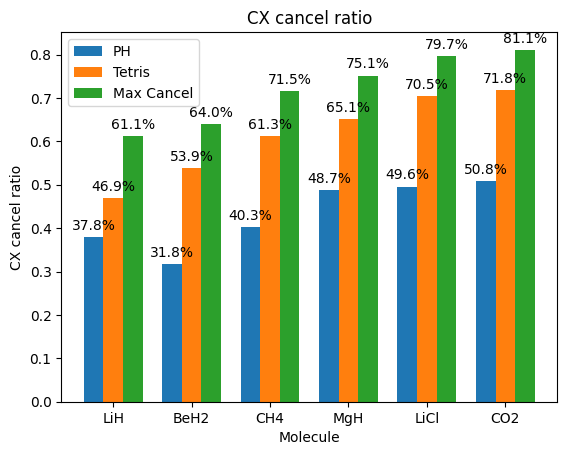

In [4]:
x = np.arange(len(categories))

# Define the width of each bar
bar_width = 0.25

# Create the grouped bar chart
plt.bar(x - bar_width, ph_cx_cancel_ratio, bar_width, label='PH')
plt.bar(x, tetris_cx_cancel_ratio, bar_width, label='Tetris')
plt.bar(x + bar_width, max_cancel_cx_cancel_ratio, bar_width, label='Max Cancel')
# Add labels to the bars
for i in range(len(categories)):
    plt.text(x[i] - bar_width, ph_cx_cancel_ratio[i] + 0.01, str(round(ph_cx_cancel_ratio[i] * 100, 1)) + '%', ha='center', va='bottom')
    plt.text(x[i], tetris_cx_cancel_ratio[i] + 0.01, str(round(tetris_cx_cancel_ratio[i] * 100, 1)) + '%', ha='center', va='bottom')
    plt.text(x[i] + bar_width, max_cancel_cx_cancel_ratio[i] + 0.01, str(round(max_cancel_cx_cancel_ratio[i] * 100, 1)) + '%', ha='center', va='bottom')

# Add category labels to the x-axis
plt.xticks(x, categories)

# Add labels and a legend
plt.xlabel('Molecule')
plt.ylabel('CX cancel ratio')
plt.title('CX cancel ratio')
plt.legend()

# Show the plot
plt.show()


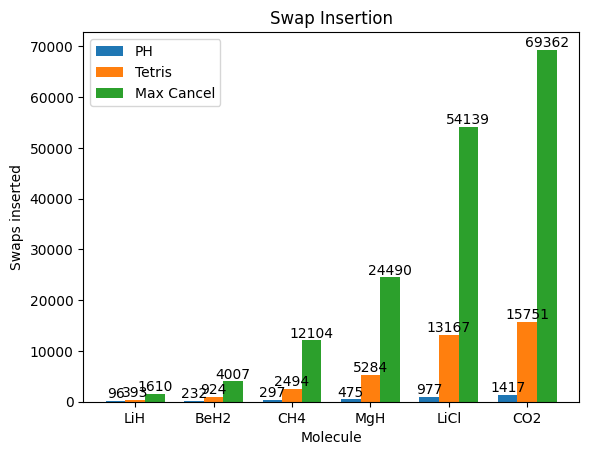

In [5]:
x = np.arange(len(categories))

# Define the width of each bar
bar_width = 0.25

# Create the grouped bar chart
plt.bar(x - bar_width, ph_swaps, bar_width, label='PH')
plt.bar(x, tetris_swaps, bar_width, label='Tetris')
plt.bar(x + bar_width, max_cancel_swaps, bar_width, label='Max Cancel')
# Add labels to the bars
for i in range(len(categories)):
    plt.text(x[i] - bar_width, ph_swaps[i] + 1, str(ph_swaps[i]), ha='center', va='bottom')
    plt.text(x[i],  tetris_swaps[i] + 1, str(tetris_swaps[i]), ha='center', va='bottom')
    plt.text(x[i] + bar_width, max_cancel_swaps[i] + 1, str(max_cancel_swaps[i]), ha='center', va='bottom')

# Add category labels to the x-axis
plt.xticks(x, categories)

# Add labels and a legend
plt.xlabel('Molecule')
plt.ylabel('Swaps inserted')
plt.title('Swap Insertion')
plt.legend()

# Show the plot
plt.show()


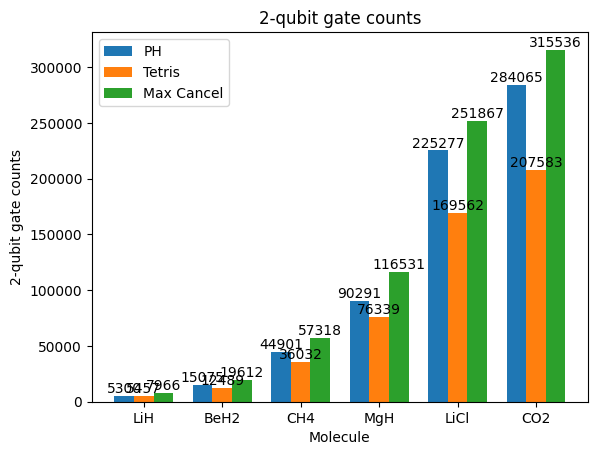

In [6]:
x = np.arange(len(categories))

# Define the width of each bar
bar_width = 0.25

# Create the grouped bar chart
plt.bar(x - bar_width, ph_cnots, bar_width, label='PH')
plt.bar(x, tetris_cnots, bar_width, label='Tetris')
plt.bar(x + bar_width, max_cancel_cnots, bar_width, label='Max Cancel')
# Add labels to the bars
for i in range(len(categories)):
    plt.text(x[i] - bar_width, ph_cnots[i] + 1, str(ph_cnots[i]), ha='center', va='bottom')
    plt.text(x[i],  tetris_cnots[i] + 1, str(tetris_cnots[i]), ha='center', va='bottom')
    plt.text(x[i] + bar_width, max_cancel_cnots[i] + 1, str(max_cancel_cnots[i]), ha='center', va='bottom')

# Add category labels to the x-axis
plt.xticks(x, categories)

# Add labels and a legend
plt.xlabel('Molecule')
plt.ylabel('2-qubit gate counts')
plt.title('2-qubit gate counts')
plt.legend()

# Show the plot
plt.show()
